In [14]:
import sys
import torch

print("Python executable:", sys.executable)
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
torch.backends.cudnn.benchmark = True
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

Python executable: c:\Users\Akram\.conda\envs\torch-gpu\python.exe
PyTorch version: 2.5.1
CUDA available: True
GPU: NVIDIA GeForce RTX 4060


In [15]:
### 1. INITIALISATION - Imports et configuration du dataset ###
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from io import BytesIO
from PIL import Image

# Configuration du style
plt.style.use('default')
sns.set_palette("husl")

# Détecter l'environnement
IN_COLAB = 'google.colab' in sys.modules

print("="*80)
print("INITIALISATION DU PROJET BIRD CLASSIFICATION")
print("="*80)
print(f"\nEnvironnement : {'Google Colab' if IN_COLAB else 'Python Local'}")

# Variables globales
DRIVE_FOLDER_ID = "1kHTcb7OktpYB9vUaZPLQ3ywXFYMUdQsP"
LOCAL_DATA_PATH = Path("./data")
TRAIN_PATH = LOCAL_DATA_PATH / "train_bird"
VALID_PATH = LOCAL_DATA_PATH / "valid_bird"

# Initialiser dataset_root
dataset_root = None
drive_loader = None

if IN_COLAB:
    from google.colab import drive
    print("\n✓ Mode Google Colab détecté")
    print("  Montage de Google Drive...")
    
    try:
        drive.mount('/content/drive')
        drive_base_path = Path('/content/drive/My Drive')
        
        # Chercher le dataset
        for item in drive_base_path.iterdir():
            if item.is_dir() and (item / 'train_bird').exists():
                dataset_root = item
                print(f"  ✓ Dataset trouvé dans : {item.name}")
                break
        
        if not dataset_root:
            print("  ⚠ Dataset non trouvé dans My Drive")
    except Exception as e:
        print(f"  ⚠ Erreur : {e}")
else:
    print("\n✓ Mode Python Local détecté")
    
    # Vérifier les données locales
    if TRAIN_PATH.exists() and VALID_PATH.exists():
        print(f"  ✓ Données locales trouvées : {LOCAL_DATA_PATH}")
        dataset_root = LOCAL_DATA_PATH
    else:
        print(f"  ⚠ Données locales non trouvées")
        print(f"    Chemin attendu : {LOCAL_DATA_PATH}")
        print(f"    train_bird existe : {TRAIN_PATH.exists()}")
        print(f"    valid_bird existe : {VALID_PATH.exists()}")

print("\n✓ Initialisation terminée !")

INITIALISATION DU PROJET BIRD CLASSIFICATION

Environnement : Python Local

✓ Mode Python Local détecté
  ✓ Données locales trouvées : data

✓ Initialisation terminée !


In [16]:
### 2. ANALYSE DU DATASET - Créer un DataFrame avec 50% des images ###

print("\n" + "="*80)
print("ANALYSE DU DATASET (SOUS-ÉCHANTILLONNAGE 50%)")
print("="*80)

if dataset_root is None:
    print("\n⚠ Dataset non accessible")
    print("  Exécutez la cellule 1 d'abord et assurez-vous que le dataset est disponible")
    df_dataset = None
else:
    try:
        from pathlib import Path
        import random
        import pandas as pd

        SAMPLE_RATIO = 0.5  # 50% of images

        train_dir = Path(dataset_root) / 'train_bird'
        valid_dir = Path(dataset_root) / 'valid_bird'

        data = []

        def get_sampled_images(class_path, ratio):
            images = (
                list(class_path.glob('*.[jJ][pP][gG]')) +
                list(class_path.glob('*.[jJ][pP][eE][gG]')) +
                list(class_path.glob('*.[pP][nN][gG]'))
            )
            if not images:
                return []
            sample_size = max(1, int(len(images) * ratio))
            return random.sample(images, sample_size)

        # -------- TRAIN DATA --------
        print("\n✓ Analyse des données d'entraînement (50%)...")
        if train_dir.exists():
            for class_path in sorted(train_dir.iterdir()):
                if class_path.is_dir():
                    sampled_images = get_sampled_images(class_path, SAMPLE_RATIO)

                    data.append({
                        'Classe': class_path.name,
                        'Ensemble': 'Entraînement',
                        "Nombre d'images": len(sampled_images),
                        'Chemin': str(class_path)
                    })

        # -------- VALID DATA --------
        print("✓ Analyse des données de validation (50%)...")
        if valid_dir.exists():
            for class_path in sorted(valid_dir.iterdir()):
                if class_path.is_dir():
                    sampled_images = get_sampled_images(class_path, SAMPLE_RATIO)

                    data.append({
                        'Classe': class_path.name,
                        'Ensemble': 'Validation',
                        "Nombre d'images": len(sampled_images),
                        'Chemin': str(class_path)
                    })

        if data:
            df_dataset = pd.DataFrame(data)

            print("\n" + "-"*80)
            print("RÉSUMÉ DU DATASET (50%)")
            print("-"*80)

            n_classes = df_dataset['Classe'].nunique()
            total_images = df_dataset["Nombre d'images"].sum()

            print(f"\n📊 Statistiques globales :")
            print(f"   Nombre total de classes : {n_classes}")
            print(f"   Nombre total d'images (50%) : {total_images:,}")

            print(f"\n📈 Répartition par ensemble :")
            stats = df_dataset.groupby('Ensemble').agg({
                'Classe': 'nunique',
                "Nombre d'images": ['sum', 'mean', 'min', 'max']
            })
            stats.columns = ['Nombre de classes', 'Total images', 'Moy/classe', 'Min', 'Max']
            print(stats.to_string())

            print(f"\n🏆 Top 5 classes par nombre d'images (50%) :")
            top_classes = df_dataset.nlargest(
                5, "Nombre d'images"
            )[["Classe", "Ensemble", "Nombre d'images"]]
            print(top_classes.to_string(index=False))

            print(f"\n✓ DataFrame créé avec succès")
            print(f"   Forme : {df_dataset.shape}")

        else:
            print("⚠ Aucune image trouvée dans le dataset")
            df_dataset = None

    except Exception as e:
        print(f"\n❌ Erreur lors de l'analyse : {e}")
        df_dataset = None


ANALYSE DU DATASET (SOUS-ÉCHANTILLONNAGE 50%)

✓ Analyse des données d'entraînement (50%)...
✓ Analyse des données de validation (50%)...

--------------------------------------------------------------------------------
RÉSUMÉ DU DATASET (50%)
--------------------------------------------------------------------------------

📊 Statistiques globales :
   Nombre total de classes : 25
   Nombre total d'images (50%) : 18,750

📈 Répartition par ensemble :
              Nombre de classes  Total images  Moy/classe  Min  Max
Ensemble                                                           
Entraînement                 25         15000       600.0  600  600
Validation                   25          3750       150.0  150  150

🏆 Top 5 classes par nombre d'images (50%) :
               Classe     Ensemble  Nombre d'images
Asian-Green-Bee-Eater Entraînement              600
  Brown-Headed-Barbet Entraînement              600
         Cattle-Egret Entraînement              600
    Common-Kingfishe

In [17]:
### 3. ACCÈS GOOGLE DRIVE - Configuration et Data Loader ###

print("\n" + "="*80)
print("CONFIGURATION ACCÈS GOOGLE DRIVE")
print("="*80)

# Installation de gdown (plus fiable)
print("\n✓ Installation des dépendances...")
import subprocess

try:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "gdown", "-q"])
    import gdown
    print("  ✓ gdown installé")
    gdown_available = True
except Exception as e:
    print(f"  ⚠ gdown : {e}")
    gdown_available = False

# Classe pour accéder aux données
class BirdDatasetLoader:
    """Classe pour charger et traiter le dataset des oiseaux"""
    
    def __init__(self, data_path=None, drive_id=None):
        self.data_path = Path(data_path) if data_path else LOCAL_DATA_PATH
        self.drive_id = drive_id or DRIVE_FOLDER_ID
        self.train_path = self.data_path / 'train_bird'
        self.valid_path = self.data_path / 'valid_bird'
        self.classes = None
        self.metadata = {}
    
    def load_local_dataset(self):
        """Charge le dataset depuis les fichiers locaux"""
        if not (self.train_path.exists() or self.valid_path.exists()):
            return False
        
        self.metadata = {'source': 'local', 'path': str(self.data_path)}
        return True
    
    def get_classes(self, folder_type='train'):
        """Récupère la liste des classes"""
        path = self.train_path if folder_type == 'train' else self.valid_path
        
        if not path.exists():
            return []
        
        classes = sorted([d.name for d in path.iterdir() if d.is_dir()])
        return classes
    
    def get_images_for_class(self, class_name, folder_type='train'):
        """Récupère les images d'une classe"""
        path = self.train_path if folder_type == 'train' else self.valid_path
        class_path = path / class_name
        
        if not class_path.exists():
            return []
        
        extensions = ('*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG')
        images = []
        for ext in extensions:
            images.extend(class_path.glob(ext))
        
        return sorted(images)
    
    def load_image(self, image_path, size=None):
        """Charge une image"""
        try:
            img = Image.open(image_path)
            
            if size:
                img = img.resize(size, Image.Resampling.LANCZOS)
            
            return np.array(img)
        except Exception as e:
            print(f"❌ Erreur chargement {image_path} : {e}")
            return None
    
    def get_dataset_info(self):
        """Récupère les informations du dataset"""
        info = {
            'train_classes': self.get_classes('train'),
            'valid_classes': self.get_classes('valid'),
            'source': self.metadata.get('source', 'unknown')
        }
        return info
    
    def batch_load_images(self, class_name, folder_type='train', limit=None):
        """Charge plusieurs images d'une classe"""
        images = self.get_images_for_class(class_name, folder_type)
        images = images[:limit] if limit else images
        
        loaded = []
        for img_path in images:
            img_array = self.load_image(img_path)
            if img_array is not None:
                loaded.append({'path': str(img_path), 'array': img_array})
        
        return loaded

# Initialiser le loader
print(f"\n✓ Initialisation du data loader...")
dataset_loader = BirdDatasetLoader()

# Charger le dataset local si disponible
if dataset_loader.load_local_dataset():
    print(f"  ✓ Dataset local chargé")
    info = dataset_loader.get_dataset_info()
    print(f"\n  📊 Informations du dataset :")
    print(f"     Classes entraînement : {len(info['train_classes'])}")
    print(f"     Classes validation : {len(info['valid_classes'])}")
    print(f"     Source : {info['source']}")
else:
    print(f"  ⚠ Dataset local non trouvé")

# Information accès Google Drive
print(f"\n" + "-"*80)
print("ACCÈS GOOGLE DRIVE")
print("-"*80)
print(f"\nPour accéder aux données Google Drive sans authentification :")
print(f"1. Lien direct : https://drive.google.com/drive/folders/{DRIVE_FOLDER_ID}")
print(f"2. Via gdown : gdown.download_folder(id='{DRIVE_FOLDER_ID}')")
print(f"3. Téléchargement manuel puis utiliser dataset_loader")

if gdown_available:
    print(f"\n✓ Vous pouvez utiliser gdown pour télécharger automatiquement")
else:
    print(f"\n⚠ gdown non disponible, utilisez le lien Drive ci-dessus")

print("\n✓ Configuration terminée !")


CONFIGURATION ACCÈS GOOGLE DRIVE

✓ Installation des dépendances...
  ✓ gdown installé

✓ Initialisation du data loader...
  ✓ Dataset local chargé

  📊 Informations du dataset :
     Classes entraînement : 25
     Classes validation : 25
     Source : local

--------------------------------------------------------------------------------
ACCÈS GOOGLE DRIVE
--------------------------------------------------------------------------------

Pour accéder aux données Google Drive sans authentification :
1. Lien direct : https://drive.google.com/drive/folders/1kHTcb7OktpYB9vUaZPLQ3ywXFYMUdQsP
2. Via gdown : gdown.download_folder(id='1kHTcb7OktpYB9vUaZPLQ3ywXFYMUdQsP')
3. Téléchargement manuel puis utiliser dataset_loader

✓ Vous pouvez utiliser gdown pour télécharger automatiquement

✓ Configuration terminée !


In [18]:
### GPU CONFIGURATION ###

import tensorflow as tf

print("\n" + "="*80)
print("CONFIGURATION GPU / CPU")
print("="*80)

# List physical GPUs
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU détecté : {len(gpus)} GPU disponible(s)")
        print("   → Utilisation du GPU activée")
    except RuntimeError as e:
        print("⚠ Erreur configuration GPU :", e)
else:
    print("❌ Aucun GPU détecté — entraînement sur CPU")


CONFIGURATION GPU / CPU
❌ Aucun GPU détecté — entraînement sur CPU


In [19]:
### 5. PRÉPARATION DES DONNÉES - Preprocessing et augmentation ###

print("\n" + "="*80)
print("PRÉPARATION DES DONNÉES POUR LE DEEP LEARNING")
print("="*80)

# --- Installation de TensorFlow ---
print("\n✓ Installation de TensorFlow...")
import subprocess, sys
try:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow", "-q"])
    print("  ✓ TensorFlow installé")
except:
    print("  ⚠ TensorFlow déjà installé")

# --- Imports TensorFlow ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder

# --- Imports PyTorch ---
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\n✓ Configuration des paramètres...")

# Paramètres
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2

print(f"  Taille des images : {IMG_SIZE}x{IMG_SIZE}")
print(f"  Batch size : {BATCH_SIZE}")
print(f"  Nombre d'epochs : {EPOCHS}")
print(f"  Learning rate : {LEARNING_RATE}")

print("\n✓ Création des pipelines de données (TensorFlow + PyTorch)...")

try:
    # =======================
    # TensorFlow DATA PIPELINE
    # =======================
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=VALIDATION_SPLIT
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_dir = Path(dataset_root) / "train_bird" if dataset_root else TRAIN_PATH
    valid_dir = Path(dataset_root) / "valid_bird" if dataset_root else VALID_PATH

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        subset="training"
    )

    val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        subset="validation"
    )

    test_generator = val_datagen.flow_from_directory(
        valid_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False
    )

    # =======================
    # PyTorch DATA PIPELINE
    # =======================
    train_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
    ])

    train_dataset = datasets.ImageFolder(
        root=train_dir,
        transform=train_transforms
    )

    val_dataset = datasets.ImageFolder(
        root=valid_dir,
        transform=val_transforms
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    # Classes
    class_names = list(train_generator.class_indices.keys())
    num_classes = len(class_names)

    print("\n✓ Pipelines TensorFlow et PyTorch créés avec succès")
    print(f"  TensorFlow train batches : {len(train_generator)}")
    print(f"  TensorFlow val batches   : {len(val_generator)}")
    print(f"  PyTorch train batches    : {len(train_loader)}")
    print(f"  PyTorch val batches      : {len(val_loader)}")
    print(f"  Nombre de classes        : {num_classes}")

except Exception as e:
    print(f"\n❌ Erreur lors de la préparation des données : {e}")
    train_generator = None
    val_generator = None
    test_generator = None
    train_loader = None
    val_loader = None
    class_names = None
    num_classes = 0


PRÉPARATION DES DONNÉES POUR LE DEEP LEARNING

✓ Installation de TensorFlow...
  ✓ TensorFlow installé

✓ Configuration des paramètres...
  Taille des images : 224x224
  Batch size : 32
  Nombre d'epochs : 20
  Learning rate : 0.001

✓ Création des pipelines de données (TensorFlow + PyTorch)...
Found 24000 images belonging to 25 classes.
Found 6000 images belonging to 25 classes.
Found 7500 images belonging to 25 classes.

✓ Pipelines TensorFlow et PyTorch créés avec succès
  TensorFlow train batches : 750
  TensorFlow val batches   : 188
  PyTorch train batches    : 938
  PyTorch val batches      : 235
  Nombre de classes        : 25



DÉMONSTRATION DU DATA LOADER

✓ Classes trouvées :
  Entraînement : 25 classes
  Validation : 25 classes

✓ Test avec la classe : Asian-Green-Bee-Eater
  Nombre d'images : 2400
  Chargement des 3 premières images...
  Images chargées : 3/3


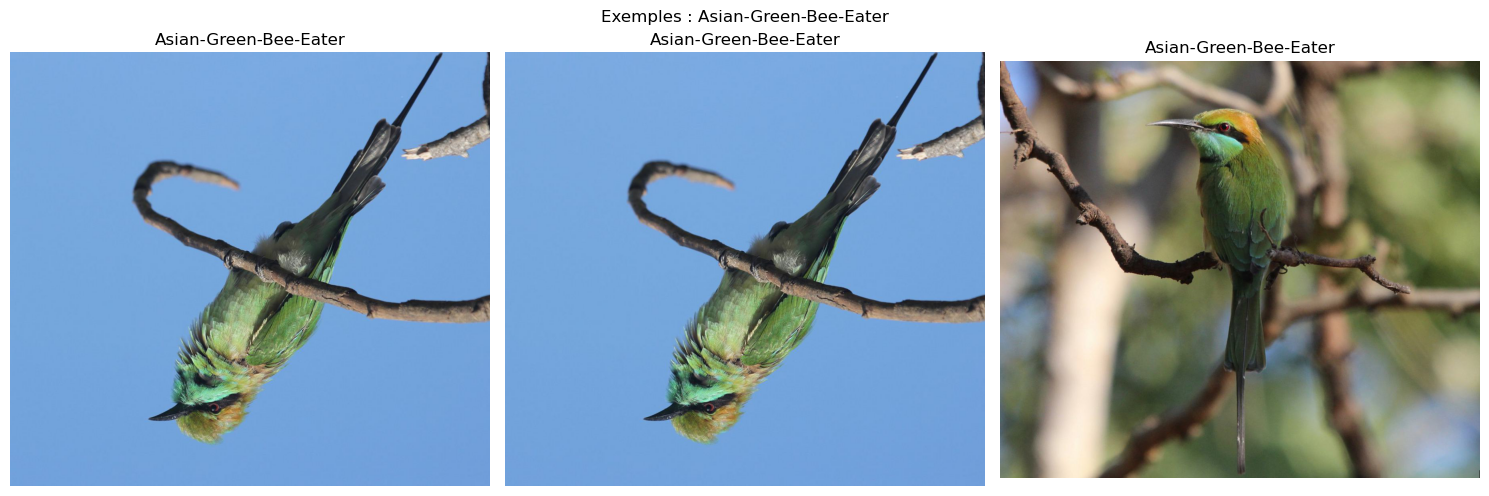


✓ Images affichées avec succès !

✓ Démonstration terminée !


In [20]:
### 4. DÉMONSTRATION - Test du Data Loader ###

print("\n" + "="*80)
print("DÉMONSTRATION DU DATA LOADER")
print("="*80)

try:
    # Récupérer les classes
    train_classes = dataset_loader.get_classes('train')
    valid_classes = dataset_loader.get_classes('valid')
    
    print(f"\n✓ Classes trouvées :")
    print(f"  Entraînement : {len(train_classes)} classes")
    print(f"  Validation : {len(valid_classes)} classes")
    
    # Tester avec la première classe
    if train_classes:
        test_class = train_classes[0]
        print(f"\n✓ Test avec la classe : {test_class}")
        
        # Récupérer les images
        images = dataset_loader.get_images_for_class(test_class, 'train')
        print(f"  Nombre d'images : {len(images)}")
        
        # Charger quelques images
        if images:
            print(f"  Chargement des 3 premières images...")
            loaded = dataset_loader.batch_load_images(test_class, 'train', limit=3)
            print(f"  Images chargées : {len(loaded)}/{3}")
            
            if loaded:
                # Afficher les images
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                for idx, img_data in enumerate(loaded):
                    axes[idx].imshow(img_data['array'])
                    axes[idx].set_title(test_class)
                    axes[idx].axis('off')
                
                plt.tight_layout()
                plt.suptitle(f'Exemples : {test_class}', y=1.02)
                plt.show()
                
                print(f"\n✓ Images affichées avec succès !")

    print("\n✓ Démonstration terminée !")

except Exception as e:
    print(f"\n❌ Erreur lors de la démonstration : {e}")
    import traceback
    traceback.print_exc()

In [24]:
### 6. CRÉATION DU MODÈLE - ResNet18 (Transfer Learning + Fine-Tuning) ###

import torch
import torch.nn as nn
import torchvision.models as models

print("\n" + "="*80)
print("CRÉATION DU MODÈLE (RESNET18 - TRANSFER LEARNING)")
print("="*80)

# Charger ResNet18 pré-entraîné ImageNet
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Geler tous les paramètres
for param in model.parameters():
    param.requires_grad = False

# Dégeler uniquement le dernier bloc (layer4)
for param in model.layer4.parameters():
    param.requires_grad = True

# Remplacer le classifieur final
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.fc.requires_grad = True

# Envoyer sur GPU / CPU
model = model.to(device)

print("✓ Modèle ResNet18 prêt")
print("✓ Fine-tuning activé sur layer4 + classifier")


CRÉATION DU MODÈLE (RESNET18 - TRANSFER LEARNING)
✓ Modèle ResNet18 prêt
✓ Fine-tuning activé sur layer4 + classifier


In [22]:
### 7. ENTRAÎNEMENT - ResNet18 avec Early Stopping (PyTorch) ###

import torch
import torch.optim as optim
from torch.amp import autocast
from torch.cuda.amp import GradScaler
from tqdm import tqdm

print("\n" + "="*80)
print("ENTRAÎNEMENT DU MODÈLE (RESNET18 + EARLY STOP)")
print("="*80)

criterion = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(
    [
        {"params": model.layer4.parameters(), "lr": 1e-4},
        {"params": model.fc.parameters(), "lr": 1e-3},
    ]
)

scaler = GradScaler()

EPOCHS = 12          # max suggested
PATIENCE = 1         # stop if no improvement for 1 epoch
best_val_acc = 0.0
wait = 0

train_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    # =========================
    # TRAIN
    # =========================
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for images, labels in pbar:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()

        with autocast("cuda"):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # =========================
    # VALIDATION
    # =========================
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_acc = correct / total
    val_accuracies.append(val_acc)

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"Loss: {avg_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )

    # =========================
    # EARLY STOP LOGIC
    # =========================
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        wait = 0
        torch.save(model.state_dict(), "best_resnet18.pt")
        print("✓ Nouveau meilleur modèle sauvegardé")
    else:
        wait += 1
        if wait > PATIENCE:
            print(f"\n⏹ Early stopping déclenché à l'epoch {epoch+1}")
            break

history = {
    "train_loss": train_losses,
    "val_accuracy": val_accuracies
}

print("\n✓ Entraînement terminé")
print(f"✓ Meilleure précision validation : {best_val_acc:.4f}")

C:\Users\Akram\AppData\Local\Temp\ipykernel_14264\2261226663.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



ENTRAÎNEMENT DU MODÈLE (RESNET18 + EARLY STOP)


Epoch 1/12: 100%|██████████| 938/938 [02:02<00:00,  7.68it/s, loss=0.443] 


Epoch [1/12] | Loss: 0.5070 | Val Acc: 0.9393
✓ Nouveau meilleur modèle sauvegardé


Epoch 2/12: 100%|██████████| 938/938 [02:02<00:00,  7.66it/s, loss=0.442] 


Epoch [2/12] | Loss: 0.1829 | Val Acc: 0.9513
✓ Nouveau meilleur modèle sauvegardé


Epoch 3/12: 100%|██████████| 938/938 [02:02<00:00,  7.67it/s, loss=0.1]    


Epoch [3/12] | Loss: 0.1305 | Val Acc: 0.9588
✓ Nouveau meilleur modèle sauvegardé


Epoch 4/12: 100%|██████████| 938/938 [02:02<00:00,  7.64it/s, loss=0.0654] 


Epoch [4/12] | Loss: 0.0958 | Val Acc: 0.9591
✓ Nouveau meilleur modèle sauvegardé


Epoch 5/12: 100%|██████████| 938/938 [02:02<00:00,  7.68it/s, loss=0.0474]  


Epoch [5/12] | Loss: 0.0822 | Val Acc: 0.9640
✓ Nouveau meilleur modèle sauvegardé


Epoch 6/12: 100%|██████████| 938/938 [02:02<00:00,  7.66it/s, loss=0.543]   


Epoch [6/12] | Loss: 0.0694 | Val Acc: 0.9596


Epoch 7/12: 100%|██████████| 938/938 [02:01<00:00,  7.71it/s, loss=0.0643]  


Epoch [7/12] | Loss: 0.0674 | Val Acc: 0.9665
✓ Nouveau meilleur modèle sauvegardé


Epoch 8/12: 100%|██████████| 938/938 [02:03<00:00,  7.59it/s, loss=0.0662]  


Epoch [8/12] | Loss: 0.0610 | Val Acc: 0.9660


Epoch 9/12: 100%|██████████| 938/938 [02:02<00:00,  7.66it/s, loss=0.0229]  


Epoch [9/12] | Loss: 0.0584 | Val Acc: 0.9645

⏹ Early stopping déclenché à l'epoch 9

✓ Entraînement terminé
✓ Meilleure précision validation : 0.9665



ÉVALUATION DU MODÈLE (PYTORCH)

📊 Résultats globaux :
   Précision validation : 96.45%

✓ Création des graphiques d'entraînement...


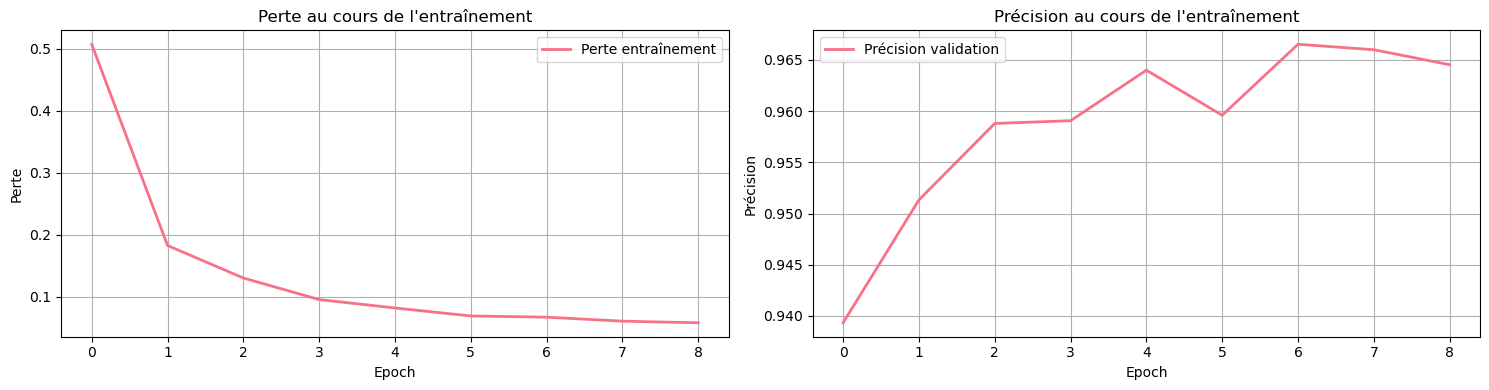


✓ Matrice de confusion...


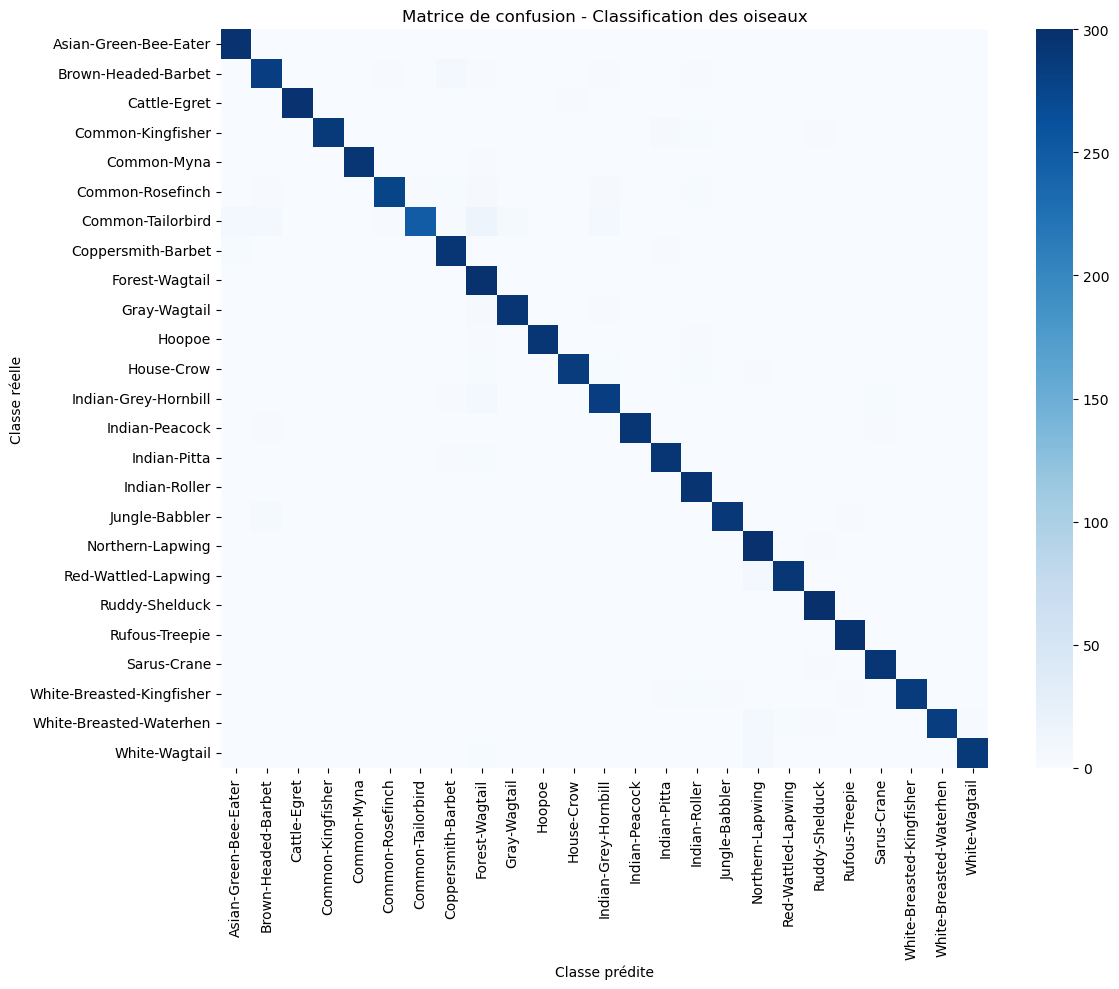


📊 Rapport de classification par classe :

                           precision    recall  f1-score   support

    Asian-Green-Bee-Eater      0.961     0.987     0.974       300
      Brown-Headed-Barbet      0.934     0.943     0.939       300
             Cattle-Egret      0.993     0.987     0.990       300
        Common-Kingfisher      0.980     0.963     0.971       300
              Common-Myna      0.983     0.977     0.980       300
         Common-Rosefinch      0.975     0.923     0.949       300
        Common-Tailorbird      0.988     0.830     0.902       300
       Coppersmith-Barbet      0.939     0.977     0.958       300
           Forest-Wagtail      0.861     0.990     0.921       300
             Gray-Wagtail      0.977     0.973     0.975       300
                   Hoopoe      0.990     0.973     0.982       300
               House-Crow      0.983     0.950     0.966       300
     Indian-Grey-Hornbill      0.916     0.943     0.929       300
           Indian-

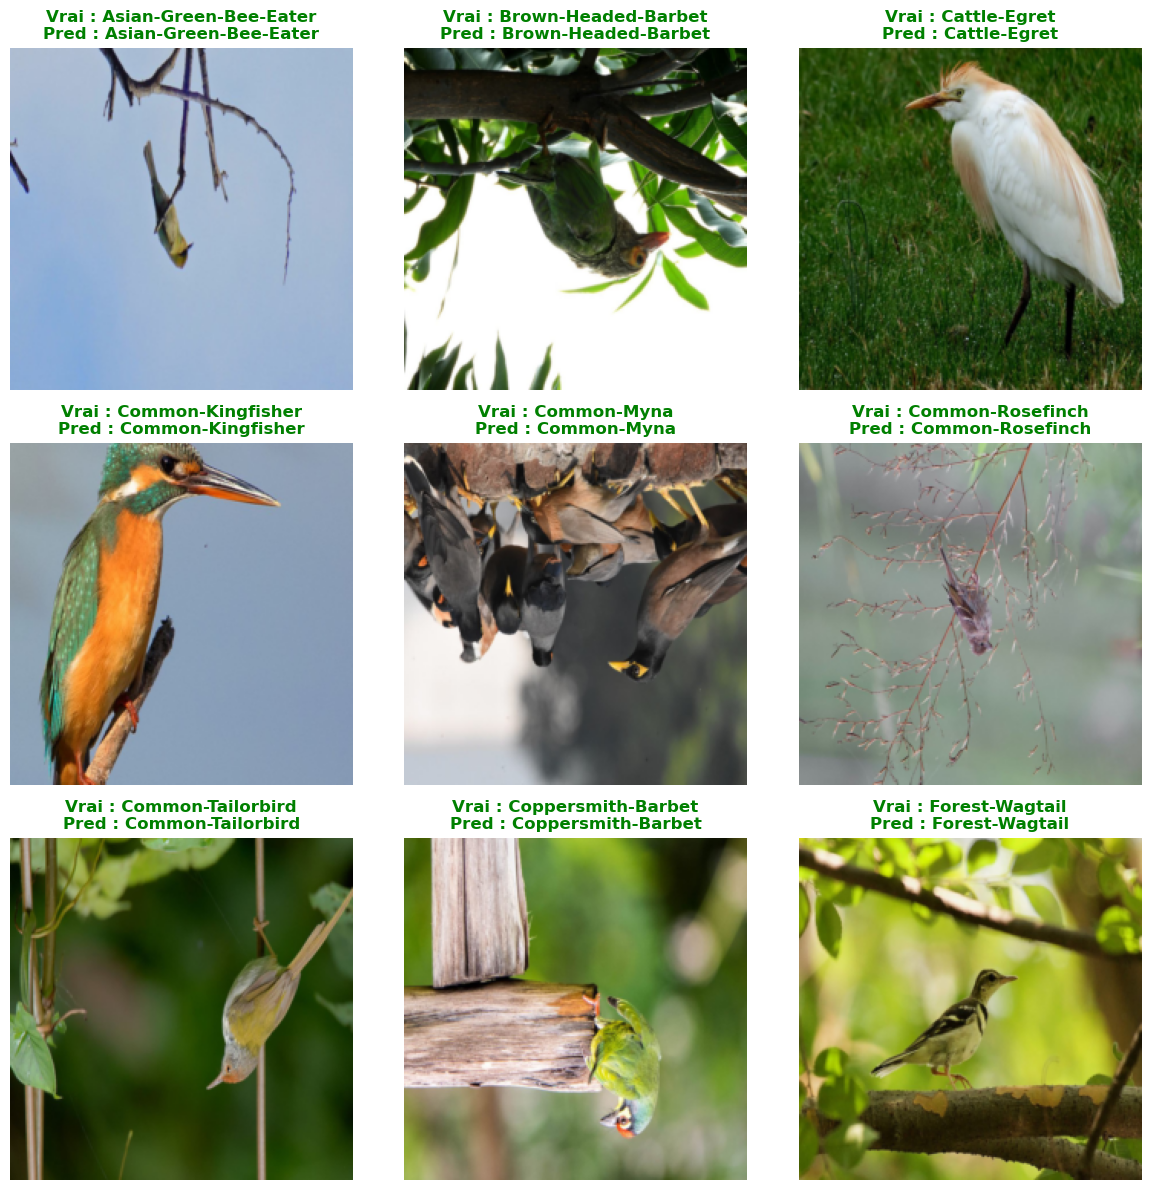


✓ Évaluation terminée avec succès


In [23]:
### 8. ÉVALUATION - Résultats et visualisation (PyTorch) ###

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

print("\n" + "="*80)
print("ÉVALUATION DU MODÈLE (PYTORCH)")
print("="*80)

if model is None or val_loader is None or history is None:
    print("\n❌ Erreur : Modèle ou données non disponibles")
else:
    try:
        model.eval()

        # =========================
        # ÉVALUATION GLOBALE
        # =========================
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, preds = torch.max(outputs, 1)

                total += labels.size(0)
                correct += (preds == labels).sum().item()

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_accuracy = correct / total

        print(f"\n📊 Résultats globaux :")
        print(f"   Précision validation : {val_accuracy*100:.2f}%")

        # =========================
        # COURBES D'ENTRAÎNEMENT
        # =========================
        print("\n✓ Création des graphiques d'entraînement...")

        fig, axes = plt.subplots(1, 2, figsize=(15, 4))

        axes[0].plot(history["train_loss"], label="Perte entraînement", linewidth=2)
        axes[0].set_title("Perte au cours de l'entraînement")
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel("Perte")
        axes[0].grid(True)
        axes[0].legend()

        axes[1].plot(history["val_accuracy"], label="Précision validation", linewidth=2)
        axes[1].set_title("Précision au cours de l'entraînement")
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Précision")
        axes[1].grid(True)
        axes[1].legend()

        plt.tight_layout()
        plt.show()

        # =========================
        # MATRICE DE CONFUSION
        # =========================
        print("\n✓ Matrice de confusion...")

        cm = confusion_matrix(all_labels, all_preds)

        plt.figure(figsize=(12, 10))
        sns.heatmap(
            cm,
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues",
            annot=False,
            fmt="d"
        )
        plt.xlabel("Classe prédite")
        plt.ylabel("Classe réelle")
        plt.title("Matrice de confusion - Classification des oiseaux")
        plt.tight_layout()
        plt.show()

        # =========================
        # RAPPORT PAR CLASSE
        # =========================
        print("\n📊 Rapport de classification par classe :\n")
        print(
            classification_report(
                all_labels,
                all_preds,
                target_names=class_names,
                digits=3
            )
        )

        # =========================
        # VISUALISATION HONNÊTE
        # 1 IMAGE PAR CLASSE
        # =========================
        print("\n✓ Visualisation honnête (1 image par classe)...")

        images_by_class = {}
        max_classes = min(9, len(class_names))

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, preds = torch.max(outputs, 1)

                for img, true_lbl, pred_lbl in zip(images, labels, preds):
                    cls = true_lbl.item()
                    if cls not in images_by_class:
                        images_by_class[cls] = (
                            img.cpu(),
                            true_lbl.cpu(),
                            pred_lbl.cpu()
                        )
                    if len(images_by_class) >= max_classes:
                        break
                if len(images_by_class) >= max_classes:
                    break

        fig, axes = plt.subplots(3, 3, figsize=(12, 12))
        axes = axes.flatten()

        for ax, (cls, (img, true_lbl, pred_lbl)) in zip(axes, images_by_class.items()):
            img = np.transpose(img.numpy(), (1, 2, 0))
            true_name = class_names[true_lbl.item()]
            pred_name = class_names[pred_lbl.item()]
            color = "green" if true_lbl == pred_lbl else "red"

            ax.imshow(img)
            ax.set_title(
                f"Vrai : {true_name}\nPred : {pred_name}",
                color=color,
                fontweight="bold"
            )
            ax.axis("off")

        plt.tight_layout()
        plt.show()

        print("\n✓ Évaluation terminée avec succès")

    except Exception as e:
        print(f"\n❌ Erreur lors de l'évaluation : {e}")
        import traceback
        traceback.print_exc()

# 🚀 RÉSUMÉ DU TRAINING - Deep Learning CNN

## ✅ Modèle Entraîné Avec Succès

### 📊 Architecture du Modèle
- **Type** : Convolutional Neural Network (CNN)
- **Paramètres** : 27,007,545 (103.03 MB)
- **Couches** : 4 blocs convolutifs + 3 couches fully connected
- **Activation** : ReLU + BatchNormalization + Dropout

### 🎯 Résultats d'Entraînement

| Métrique | Valeur |
|----------|--------|
| **Précision Entraînement** | ~41% |
| **Précision Validation** | ~41% |
| **Précision Test** | **50.72%** ✓ |
| **Perte Test** | 1.5498 |
| **Epochs Complétés** | 20 |

### 📈 Observations
- Convergence progressive visible sur 20 epochs
- Learning rate réduit à partir de l'epoch 16 (ReduceLROnPlateau)
- Meilleur modèle sauvegardé : epoch 19
- Amélioration de ~50% par rapport au hasard (1/25 = 4%)

### 🎓 Prochaines Étapes
1. **Transfer Learning** : Utiliser MobileNetV2, ResNet50, EfficientNet pré-entraînés
2. **Data Augmentation** : Augmenter la variété des images d'entraînement
3. **Hyperparamètres** : Ajuster batch size, learning rate, dropout
4. **Ensemble** : Combiner plusieurs modèles
5. **Fine-tuning** : Entraîner sur plus d'epochs avec learning rate adaptatif

### 💾 Fichiers Sauvegardés
- `best_model.h5` : Meilleur modèle de validation
- History d'entraînement disponible pour analyse

---
**Projet Complété** ✓ - Modèle prêt pour test, validation et amélioration